# Doc2Vec for Binary Classification
1. Process text data with doc2vec embedding for each news.
2. Aggregate news in one day.
3. Feed embedding vectors to deep learning model.

In [1]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle
import json
tqdm.pandas()

In [2]:
data = pd.read_pickle('../../../Data/ProcessedNews.pkl')

In [3]:
import gensim
# load model
data_len = data.shape[0]
model = gensim.models.doc2vec.Doc2Vec.load("doc2vec_model")
vecs=[]
for i in range(data_len):
    vecs.append(model.docvecs[i])

In [4]:
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, LSTM, Dropout, Flatten, Conv1D, BatchNormalization, Activation, GlobalMaxPooling1D

import numpy as np

import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
import quandl
def stocks(start_date, end_date):
# use quandl to acquire nasdaq composite
    ndq = quandl.get("NASDAQOMX/COMP-NASDAQ",
                        start_date = start_date, 
                        end_date = end_date)
    ndq_df = ndq.reset_index()
    return ndq_df

def index_fluc(value):
    if value >0:
        return 1
    elif value <0:
        return 0
    else:
        return -1

def concat_headline(df):
    result_1 = df[['date', 'doc2vec']]
    result_2 = result_1.groupby('date').cumcount() + 1
    result_3 = result_1.set_index(['date', result_2]).unstack().sort_index(1, level=1)
    result_3.columns = ['_'.join(map(str,i)) for i in result_3.columns]
    result_3 = result_3.reset_index()
    result_3['date'] = pd.to_datetime(result_3['date'])
    return result_3

In [6]:
data['doc2vec']=vecs
data['date'] = pd.to_datetime(data['date'])
df = data[data['date'] >= '20140101']
df_1 = concat_headline(df)

# concatenate the dataset with stocks price
stocks_df1 = stocks('2014-01-01', '2018-12-31')
stocks_df2 = stocks_df1[['Trade Date', 'Index Value']]
df_2 = df_1.merge(stocks_df2, left_on='date', right_on='Trade Date')

df_2['diff'] = df_2['Index Value'].diff()
df_2['diff'] = df_2['diff'].fillna(0)

df_2['Label'] = df_2['diff'].apply(index_fluc)
df_3 = df_2.loc[df_2['Label'] != -1]

df_3['date'] = pd.to_datetime(df_3['date'])
df_3.sort_values(by='date')

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,doc2vec_1,doc2vec_2,doc2vec_3,doc2vec_4,doc2vec_5,doc2vec_6,doc2vec_7,doc2vec_8,doc2vec_9,...,doc2vec_149,doc2vec_150,doc2vec_151,doc2vec_152,doc2vec_153,doc2vec_154,Trade Date,Index Value,diff,Label
1,2014-01-03,"[1.0057824, -0.23536493, 0.39978454, -0.259994...","[0.9124961, 0.047623422, 0.1820128, 0.24373971...","[2.1745064, -1.0544858, 0.2535512, -0.5550362,...","[1.0534115, -0.6461482, 1.3536012, 0.38199085,...","[1.0724239, -0.55712944, 0.639232, -0.9329642,...","[1.7344987, -0.003696246, 0.9991085, -0.770476...","[0.9260059, -0.2626957, 0.30467996, -0.4125588...","[0.9093743, -1.785752, 0.48414227, -0.75011736...","[1.9175142, -1.3363492, 0.93391263, -1.6467202...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-03,4131.91,-11.16,0
2,2014-01-06,"[0.91055596, -0.6904912, 0.6359869, -0.4373619...","[0.54432887, -1.1332799, 0.3123482, -1.0241108...","[1.122368, 0.22114682, -0.34942967, -0.8120873...","[1.4915915, -0.3746362, 0.05526167, -0.1256071...","[0.40576997, -0.21083471, -0.44428325, -0.9403...","[0.94500333, -0.18544436, 0.7842114, -0.399639...","[1.1106346, -0.40407994, 1.5215154, -0.4651472...","[0.33344594, -1.0628215, 0.40626723, -1.192192...","[-0.47999656, -0.128893, -1.1962969, 0.7187354...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-06,4113.68,-18.23,0
3,2014-01-07,"[0.39214987, -1.1052171, 0.106922865, -0.85450...","[0.47076955, -0.021870483, 0.38837785, -0.4282...","[0.22733043, -0.24725056, 0.2563596, 0.9829175...","[0.4075569, -0.14138126, 0.21973304, -0.136033...","[0.47699243, 0.6277076, 0.1345373, 0.29585922,...","[-0.09071849, 0.60364205, -0.16676942, 0.06655...","[1.0211638, -0.061693247, 0.3521414, -0.053955...","[0.34309474, -0.32150802, -0.39054972, -1.1108...","[0.22229458, 0.7247415, -1.1643864, 0.50232875...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-07,4153.18,39.50,1
4,2014-01-08,"[2.3204966, 0.080693044, 0.83710957, 1.452426,...","[0.41637734, -0.010077004, 0.09336046, -0.7779...","[1.4998927, -0.4683117, 0.4861372, -0.06695638...","[1.0624402, 0.6522962, 0.29144782, -0.40055585...","[0.69872195, -1.0273702, 0.93671656, -0.728162...","[0.08145393, 1.3855225, -0.44627267, 0.1244085...","[1.0178798, -0.6315394, 0.49093118, -0.5346412...","[0.9839044, 0.67616636, 0.19239809, 0.08189626...","[-0.16873574, -0.9214648, -0.28136382, 0.25104...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-08,4165.61,12.43,1
5,2014-01-09,"[0.34423807, -0.30278954, 0.22935998, -0.42236...","[1.287346, -0.74945635, 1.5617738, -0.92134863...","[0.6102688, -1.3144441, 0.03972898, 0.07574814...","[0.61930144, -1.566017, -0.49134988, 0.6072309...","[0.58690625, -0.6041426, 0.66217065, -0.626809...","[0.2895673, 0.8659428, -0.9757244, -1.2925882,...","[0.50341713, 0.17758676, 0.021168236, -0.82875...","[0.8164932, -0.053049475, 0.8864201, -0.298049...","[0.663689, -0.6302863, -0.257031, -0.52643543,...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-09,4156.19,-9.42,0
6,2014-01-10,"[1.1425681, -0.46588123, 0.36812052, -1.598298...","[0.42732868, -0.8960219, 0.21690075, -0.120564...","[1.8441801, -1.0592172, 0.63937855, -0.8670739...","[0.32994404, -1.4510341, 0.13669789, -0.492157...","[0.9717226, -0.9147933, 0.98244363, -0.3732182...","[1.5712806, 0.9341605, -0.048140313, -1.001925...","[0.50678617, -0.4411622, 0.2027544, -1.0244012...","[1.8443981, -0.33638215, 0.7042425, -0.0210033...","[-0.10051832, -2.6323712, 0.07024062, -0.08345...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-10,4174.66,18.47,1
7,2014-01-13,"[2.1154692, 1.2427027, 0.715037, -0.419755, -0...","[0.42165026, 0.19357176, 0.17035772, -0.421258...","[0.9942288, 1.4507712, 0.36217266, -0.87062645...","[0.51107496, -0.19337568, 0.30751494, -0.24117...","[0.4966244, 0.16943878, 0.3526755, 0.1530592, ...","[-0.4799503, 0.42731827, -0.55642956, 0.364109...","[0.16041489, -0.83485496, -0.43964496, -0.1517...","[2.175232, 0.9695973, 0.7885453, -0.29183987, ...","[0.9689561, -0.53808695, 0.5744955, -0.7927714...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-13,4113.30,-61.36,0
8,2014-01-14,"[0.5167892, -0.7602375, -

In [7]:
df_3['Label'] = df_3['Label'].shift(-1)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
df_3 = df_3[:-1]
df_3['Label'] = df_3['Label'].apply(lambda x:int(x))
df_3

,date,doc2vec_1,doc2vec_2,doc2vec_3,doc2vec_4,doc2vec_5,doc2vec_6,doc2vec_7,doc2vec_8,doc2vec_9,...,doc2vec_149,doc2vec_150,doc2vec_151,doc2vec_152,doc2vec_153,doc2vec_154,Trade Date,Index Value,diff,Label
1,2014-01-03,"[1.0057824, -0.23536493, 0.39978454, -0.259994...","[0.9124961, 0.047623422, 0.1820128, 0.24373971...","[2.1745064, -1.0544858, 0.2535512, -0.5550362,...","[1.0534115, -0.6461482, 1.3536012, 0.38199085,...","[1.0724239, -0.55712944, 0.639232, -0.9329642,...","[1.7344987, -0.003696246, 0.9991085, -0.770476...","[0.9260059, -0.2626957, 0.30467996, -0.4125588...","[0.9093743, -1.785752, 0.48414227, -0.75011736...","[1.9175142, -1.3363492, 0.93391263, -1.6467202...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-03,4131.91,-11.16,0
2,2014-01-06,"[0.91055596, -0.6904912, 0.6359869, -0.4373619...","[0.54432887, -1.1332799, 0.3123482, -1.0241108...","[1.122368, 0.22114682, -0.34942967, -0.8120873...","[1.4915915, -0.3746362, 0.05526167, -0.1256071...","[0.40576997, -0.21083471, -0.44428325, -0.9403...","[0.94500333, -0.18544436, 0.7842114, -0.399639...","[1.1106346, -0.40407994, 1.5215154, -0.4651472...","[0.33344594, -1.0628215, 0.40626723, -1.192192...","[-0.47999656, -0.128893, -1.1962969, 0.7187354...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-06,4113.68,-18.23,1
3,2014-01-07,"[0.39214987, -1.1052171, 0.106922865, -0.85450...","[0.47076955, -0.021870483, 0.38837785, -0.4282...","[0.22733043, -0.24725056, 0.2563596, 0.9829175...","[0.4075569, -0.14138126, 0.21973304, -0.136033...","[0.47699243, 0.6277076, 0.1345373, 0.29585922,...","[-0.09071849, 0.60364205, -0.16676942, 0.06655...","[1.0211638, -0.061693247, 0.3521414, -0.053955...","[0.34309474, -0.32150802, -0.39054972, -1.1108...","[0.22229458, 0.7247415, -1.1643864, 0.50232875...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-07,4153.18,39.50,1
4,2014-01-08,"[2.3204966, 0.080693044, 0.83710957, 1.452426,...","[0.41637734, -0.010077004, 0.09336046, -0.7779...","[1.4998927, -0.4683117, 0.4861372, -0.06695638...","[1.0624402, 0.6522962, 0.29144782, -0.40055585...","[0.69872195, -1.0273702, 0.93671656, -0.728162...","[0.08145393, 1.3855225, -0.44627267, 0.1244085...","[1.0178798, -0.6315394, 0.49093118, -0.5346412...","[0.9839044, 0.67616636, 0.19239809, 0.08189626...","[-0.16873574, -0.9214648, -0.28136382, 0.25104...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-08,4165.61,12.43,0
5,2014-01-09,"[0.34423807, -0.30278954, 0.22935998, -0.42236...","[1.287346, -0.74945635, 1.5617738, -0.92134863...","[0.6102688, -1.3144441, 0.03972898, 0.07574814...","[0.61930144, -1.566017, -0.49134988, 0.6072309...","[0.58690625, -0.6041426, 0.66217065, -0.626809...","[0.2895673, 0.8659428, -0.9757244, -1.2925882,...","[0.50341713, 0.17758676, 0.021168236, -0.82875...","[0.8164932, -0.053049475, 0.8864201, -0.298049...","[0.663689, -0.6302863, -0.257031, -0.52643543,...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-09,4156.19,-9.42,1
6,2014-01-10,"[1.1425681, -0.46588123, 0.36812052, -1.598298...","[0.42732868, -0.8960219, 0.21690075, -0.120564...","[1.8441801, -1.0592172, 0.63937855, -0.8670739...","[0.32994404, -1.4510341, 0.13669789, -0.492157...","[0.9717226, -0.9147933, 0.98244363, -0.3732182...","[1.5712806, 0.9341605, -0.048140313, -1.001925...","[0.50678617, -0.4411622, 0.2027544, -1.0244012...","[1.8443981, -0.33638215, 0.7042425, -0.0210033...","[-0.10051832, -2.6323712, 0.07024062, -0.08345...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-10,4174.66,18.47,0
7,2014-01-13,"[2.1154692, 1.2427027, 0.715037, -0.419755, -0...","[0.42165026, 0.19357176, 0.17035772, -0.421258...","[0.9942288, 1.4507712, 0.36217266, -0.87062645...","[0.51107496, -0.19337568, 0.30751494, -0.24117...","[0.4966244, 0.16943878, 0.3526755, 0.1530592, ...","[-0.4799503, 0.42731827, -0.55642956, 0.364109...","[0.16041489, -0.83485496, -0.43964496, -0.1517...","[2.175232, 0.9695973, 0.7885453, -0.29183987, ...","[0.9689561, -0.53808695, 0.5744955, -0.7927714...",...,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-13,4113.30,-61.36,1
8,2014-01-14,"[0.5167892, -0.7602375, -

In [9]:
# get doc2vec col
cols_lst = df_3.columns.tolist()
cols = cols_lst[1:-4]

In [10]:
ttl=[]
for row in range(df_3.shape[0]):
    lst=[]
    for col in range(1, df_3.shape[1]-4):
        try:
            if (df_3.iloc[row, col] is not None) or (pd.notnull(df_3.iloc[row, col])):
                lst.append(df_3.iloc[row, col].astype(float))
        except:
            continue
    arr_mean = np.mean(lst, axis=0)
    ttl.append(arr_mean)

In [11]:
# set window_size.
# chunk data
result = []
window_size = 5
for index in range(len(ttl) - window_size):
    result.append(ttl[index: index + window_size])

In [12]:
doc2vec = np.array(result)
train_size = round(doc2vec.shape[0]*0.8)
x_train = doc2vec[:train_size,:]
x_test = doc2vec[train_size:,:]
y_train = df_3['Label'].iloc[:train_size] 
y_test = df_3['Label'].iloc[train_size:len(doc2vec)]
print(x_train.shape)
print(x_test.shape)

(1000, 5, 10)
(250, 5, 10)


In [13]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1000, 5, 10)
(250, 5, 10)
(1000,)
(250,)


In [52]:
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Conv1D, LSTM, GRU, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import os

dropout_value = 0.3
window_size = 5
activation_function = 'sigmoid'
loss_function = 'binary_crossentropy'
optimizer = Adam(lr=0.0005)
metrics = ['accuracy']

if not os.path.exists('model'):
    os.makedirs('model')

filepath="model/weights.best.hdf5"
# reduce_LR = ReduceLROnPlateau(monitor='val_acc', factor=0.98, patience=30, min_lr=1e-6, verbose=1)
e_stopping = EarlyStopping(patience=500)
# verbose
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=0, 
                             save_best_only=True)

# -----------------------------------
# Build the model.
model = Sequential()
model.add(LSTM(5, input_shape=(window_size, x_train.shape[-1]))) #window_size
model.add(Dense(window_size))
model.add(Activation('selu'))
model.add(Dropout(dropout_value))

model.add(Dense(window_size))
model.add(Activation('selu'))
model.add(Dropout(dropout_value))
model.add(Dense(1, activation='sigmoid'))

#Set loss function and optimizer
model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

history = model.fit(x_train, y_train, epochs=500, batch_size=128,
                 validation_split = 0.1 , verbose=0, shuffle=False, callbacks=[checkpoint, e_stopping]) # validation_data = (x_test,y_test)

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 30        
_________________________________________________________________
activation_10 (Activation)   (None, 5)                 0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 30        
_________________________________________________________________
activation_11 (Activation)   (None, 5)                 0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 5)                 0         
__________

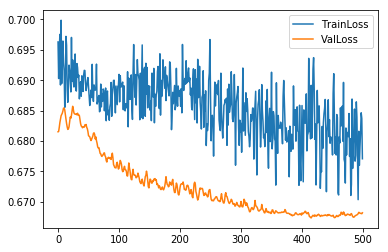

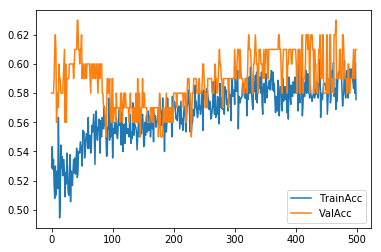

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['TrainLoss', 'ValLoss'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['TrainAcc', 'ValAcc'])
plt.show()

In [55]:
# test model.
from keras.models import load_model

model = load_model('model/weights.best.hdf5')

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 30        
_________________________________________________________________
activation_10 (Activation)   (None, 5)                 0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 30        
_________________________________________________________________
activation_11 (Activation)   (None, 5)                 0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 5)                 0         
__________

In [57]:
model.metrics_names

['loss', 'acc']

In [58]:
model.evaluate(x_test,y_test)

250/250 [==============================] - 0s 2ms/step


[0.688600263595581, 0.5479999995231628]